In [2]:
# Hierarchical RNN (HRNN) to classify Urdu digits.
# In the below MNIST example the first LSTM layer first encodes every column
# of pixels of shape (50, 1) to a column vector of shape (150,).
# The second LSTM layer encodes then these 50 column vectors of shape 
#  (50, 150) to a image vector representing the whole image. A final Dense layer is added for prediction.

import keras
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
import tensorflow as tf
# Training parameters.
batch_size = 32
nb_classes = 37
epochs = 10

# Embedding dimensions.
row_hidden = 150
col_hidden = 150

# The data, split between train and test sets.
dataset = pd.read_csv('~/Downloads/datafile2.csv').drop(['Unnamed: 0'], axis=1)
target = dataset["label"]
data = dataset.drop(["label"], axis=1)
# convert dataframe to numpy array for furthur processing
data = data.to_numpy()
target = target.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(data,
    target.astype("int"), test_size=0.20, random_state=42)

Using TensorFlow backend.


934

Text(0.5, 1.0, 'Distribution of Urdu digits in Data')

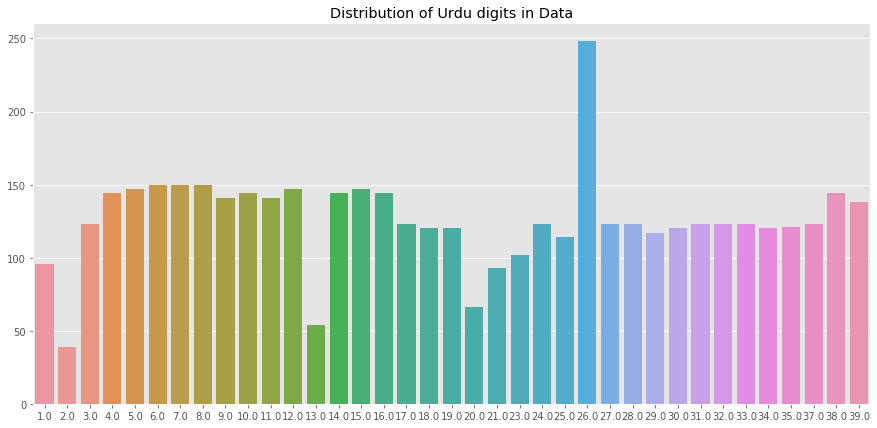

In [22]:
# Distribution of digits in dataset
y_train = dataset['label']
X = dataset.drop(['label'],axis=1)
import seaborn as sns
lab, val = np.unique(y_train,return_counts=True)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
sns.barplot(lab,val)
plt.title('Distribution of Urdu digits in Data')

In [3]:
# Reshapes data to 4D for Hierarchical RNN.
x_train = x_train.reshape(x_train.shape[0], 50, 50, 1)


In [4]:
x_test = x_test.reshape(x_test.shape[0], 50, 50, 1)


In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (3734, 50, 50, 1)
x_test shape: (934, 50, 50, 1)
y_train shape: (3734,)
y_test shape: (934,)
3734 train samples
934 test samples


In [6]:
# convert the labels from integers to vectors 
le = LabelBinarizer()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
len(y_train)

3734

In [7]:
# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


In [8]:
row, col, pixel = x_train.shape[1:]

In [9]:
# 4D input.
x = Input(shape=(row, col, pixel))

In [10]:
from keras.layers import Input, Dense, TimeDistributed
# Encodes a row of pixels using TimeDistributed Wrapper.
with tf.device('/cpu:0'):
    encoded_rows = TimeDistributed(LSTM(row_hidden))(x)
    # Encodes columns of encoded rows.
    encoded_columns = LSTM(col_hidden)(encoded_rows)
    # Final predictions and model.
    prediction = Dense(nb_classes, activation='softmax')(encoded_columns)
    model = Model(x, prediction)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

In [11]:
with tf.device('/cpu:0'):
    # Training.
    H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

Train on 3734 samples, validate on 934 samples
Epoch 1/20
3734/3734 [==============================] - 271s 73ms/step - loss: 3.4502 - accuracy: 0.0704 - val_loss: 3.1938 - val_accuracy: 0.0985
Epoch 2/20
3734/3734 [==============================] - 247s 66ms/step - loss: 3.0616 - accuracy: 0.1141 - val_loss: 3.0327 - val_accuracy: 0.1424
Epoch 3/20
3734/3734 [==============================] - 242s 65ms/step - loss: 2.9330 - accuracy: 0.1510 - val_loss: 2.7527 - val_accuracy: 0.1863
Epoch 4/20
3734/3734 [==============================] - 243s 65ms/step - loss: 2.6611 - accuracy: 0.2027 - val_loss: 2.7732 - val_accuracy: 0.1713
Epoch 5/20
3734/3734 [==============================] - 247s 66ms/step - loss: 2.3917 - accuracy: 0.2667 - val_loss: 2.3023 - val_accuracy: 0.2837
Epoch 6/20
3734/3734 [==============================] - 246s 66ms/step - loss: 2.1684 - accuracy: 0.3099 - val_loss: 2.0351 - val_accuracy: 0.3287
Epoch 7/20
3734/3734 [==============================] - 250s 67ms/step 

In [12]:
# Evaluation.
with tf.device('/cpu:0'):
    scores = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

Test loss: 0.4805808322587922
Test accuracy: 0.8211991190910339


In [13]:
from sklearn.metrics import classification_report 

# evaluate the network 
print("[INFO] evaluating network...")
# Run inference on CPU
with tf.device('/cpu:0'):
    predictions = model.predict(x_test, batch_size=32)
    print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1),
                           target_names=[str(x) for x in le.classes_]))

[INFO] evaluating network...
              precision    recall  f1-score   support

           1       0.88      1.00      0.93        21
           2       1.00      0.50      0.67         6
           3       0.90      1.00      0.95        28
           4       0.92      0.71      0.80        34
           5       0.71      0.87      0.78        31
           6       0.96      0.79      0.87        29
           7       0.46      0.74      0.57        34
           8       0.71      0.75      0.73        32
           9       1.00      0.17      0.29        29
          10       1.00      0.97      0.99        40
          11       0.79      0.79      0.79        29
          12       0.96      0.86      0.91        28
          13       1.00      0.90      0.95        10
          14       0.90      0.93      0.91        28
          15       0.67      0.91      0.77        33
          16       0.95      0.86      0.90        22
          17       1.00      0.74      0.85        3

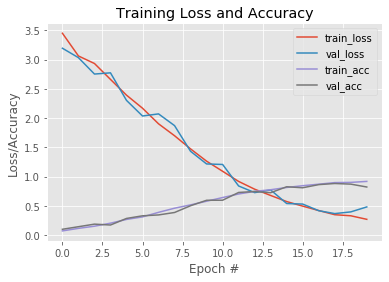

In [15]:
import matplotlib.pyplot as plt 

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [16]:
from keras.utils.vis_utils import plot_model
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 1)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 150)           91200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_1 (Dense)              (None, 37)                5587      
Total params: 277,387
Trainable params: 277,387
Non-trainable params: 0
_________________________________________________________________
None


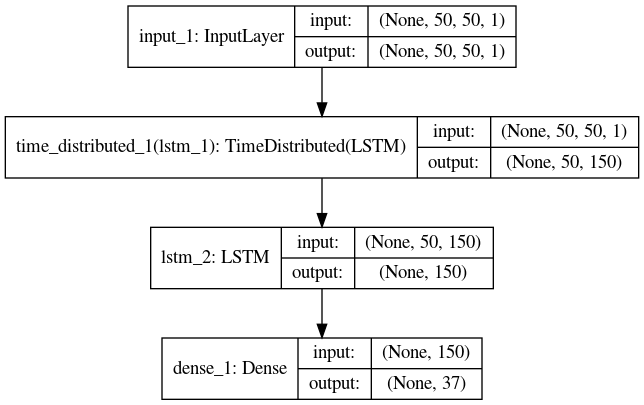

In [17]:
plot_model(model, to_file='Rnn_model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
model.save('Urdu_HRNN.model')

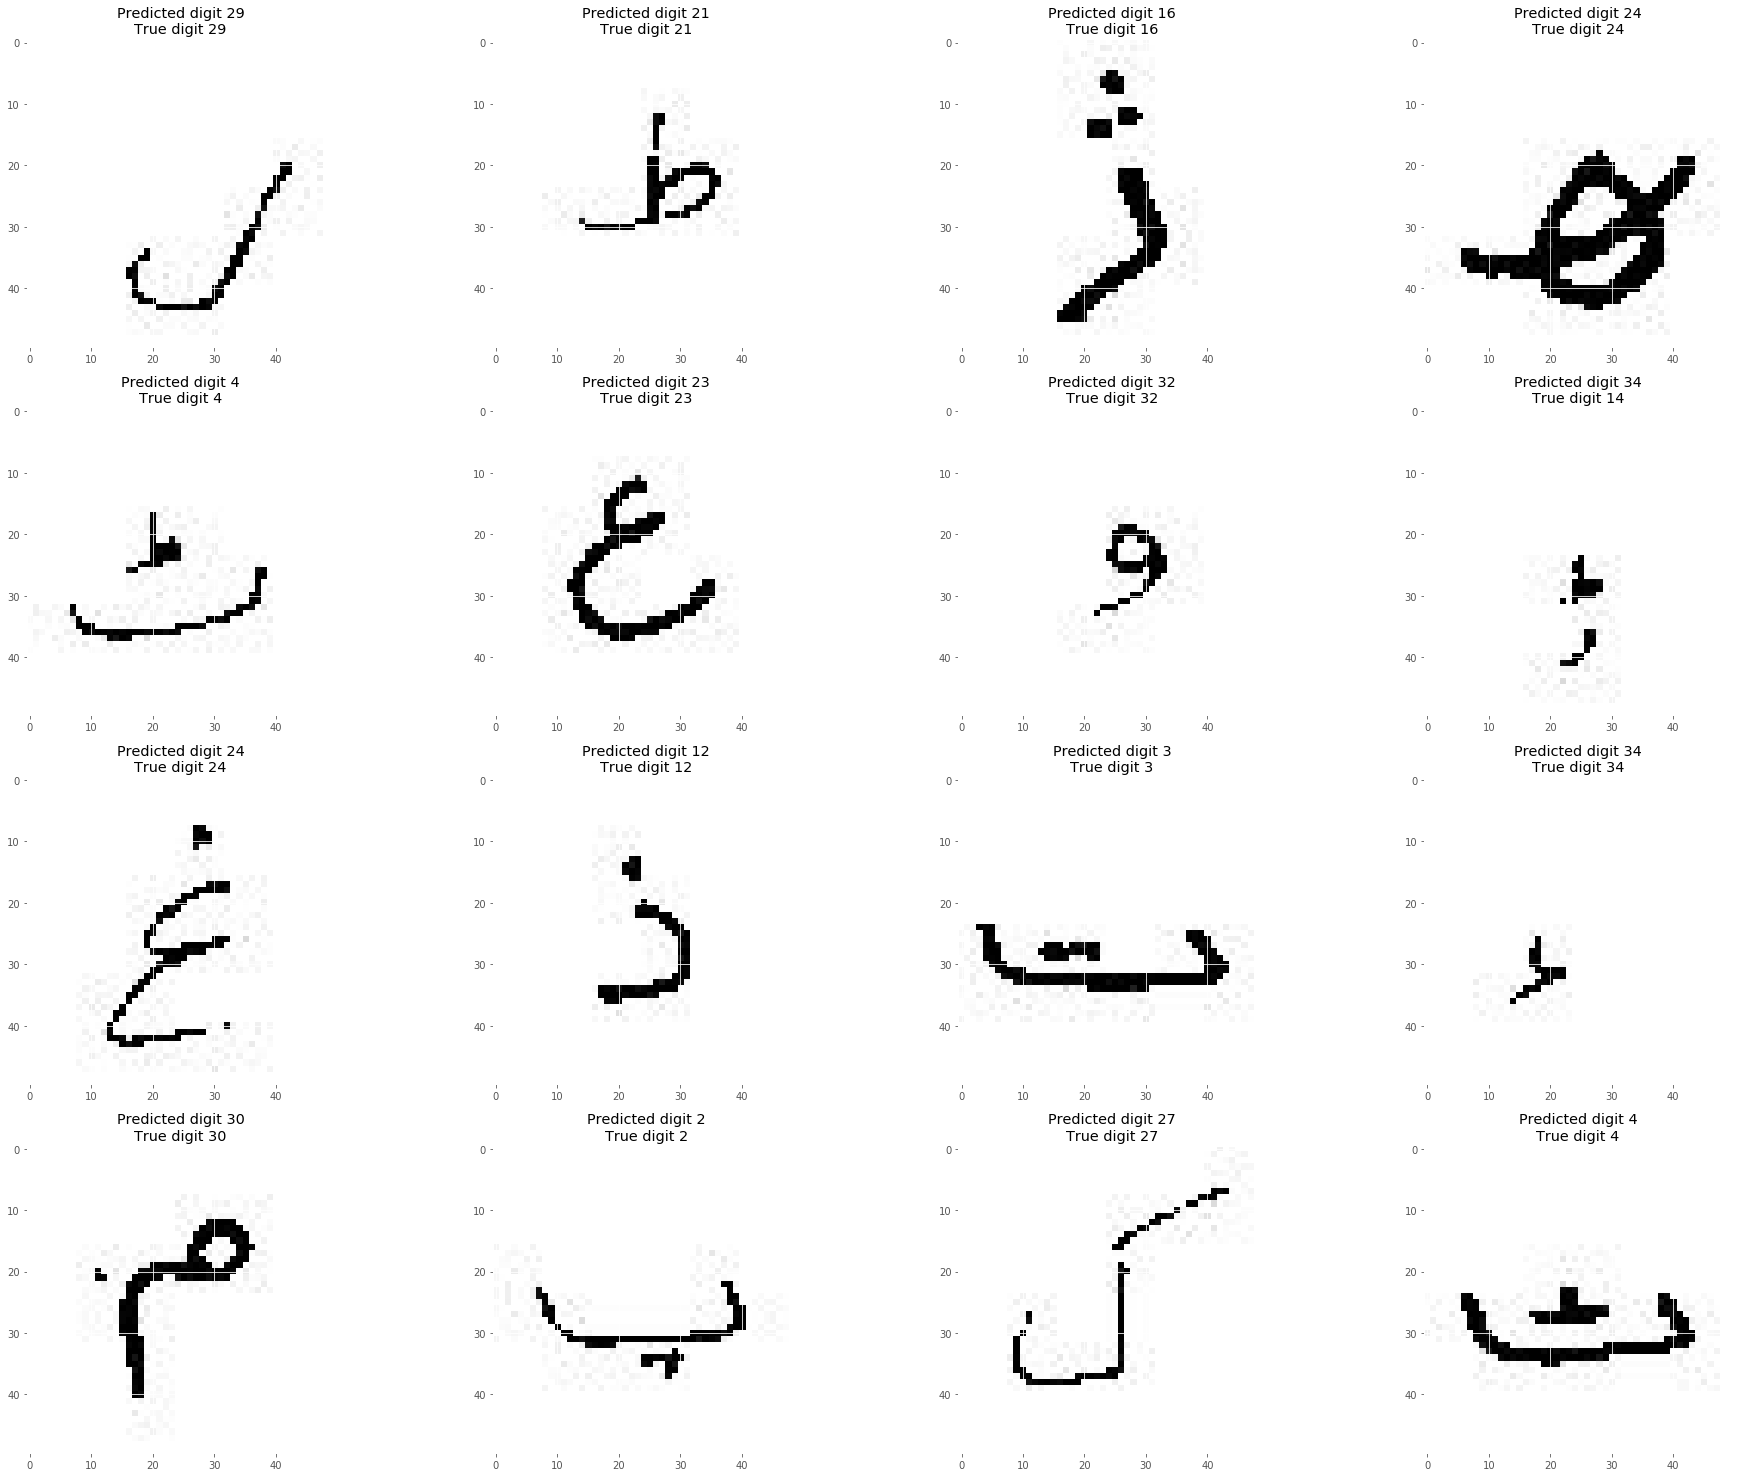

In [23]:
# Show 25 digits of data predicted by svm
fig, axis = plt.subplots(4, 4, figsize=(32, 26))

for i, ax in enumerate(axis.flat):
    ax.imshow(x_test[i].reshape(50, 50), cmap='binary')
    #ax.set(title = "KNN : predicted digit is {}".format(predictions[i]))
    ax.set(title = "Predicted digit {0}\nTrue digit {1}".format(predictions.argmax(axis=1)[i],
                                                                y_test.argmax(axis=1)[i]))

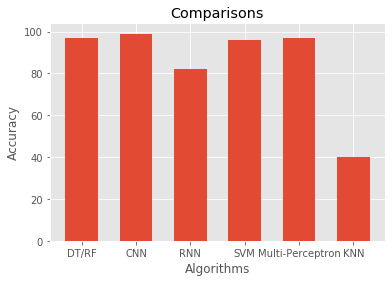

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5, 6] 
  
# heights of bars 
height = [97, 99, 82, 96, 97 ,40] 
  
# labels for bars 
tick_label = ['DT/RF', 'CNN', 'RNN', 'SVM', 'Multi-Perceptron', 'KNN'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.6) 
  
# naming the x-axis 
plt.xlabel('Algorithms') 
# naming the y-axis 
plt.ylabel('Accuracy') 
# plot title 
plt.title('Comparisons') 
  
# function to show the plot 
plt.show()


In [29]:
from sklearn.metrics import accuracy_score

int(accuracy_score(predictions.argmax(axis=1), y_test.argmax(axis=1)) * 100)

82